In [115]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
import pandas as pd


warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", message="Glyph.*missing from font")


In [116]:
# from collections import deque
# import numpy as np

# def backpush_bd_fast(G, v, s, t, r_max=1e-3):
#     """
#     使用 deque + 预取加速的 BackPush 实现。
#     假设节点标号是 0..n-1。
#     """
#     n = G.number_of_nodes()
#     # 1. 预取度 & 邻居
#     deg  = np.array([G.degree(u) for u in range(n)], dtype=float)
#     nbrs = [list(G.neighbors(u)) for u in range(n)]
    
#     # 存放三次的 pi_hat
#     pi = np.zeros((3, n), dtype=float)
    
#     for idx, x in enumerate((s, t, v)):
#         # init
#         r = np.zeros(n, dtype=float)
#         r[x] = 1.0
#         pi_hat = np.zeros(n, dtype=float)
        
#         # 活跃队列，仅放残差 >= r_max 的节点
#         dq = deque([x])
        
#         while dq:
#             u = dq.popleft()
#             ru = r[u]
#             if ru < r_max:
#                 continue
#             # 消化
#             pi_hat[u] += ru
#             r[u] = 0.0
            
#             share = ru / deg[u]
#             for w in nbrs[u]:
#                 old = r[w]
#                 r[w] += share
#                 # 刚好从 below->above
#                 if old < r_max <= r[w]:
#                     dq.append(w)
        
#         pi[idx] = pi_hat
    
#     # 3. 计算近似 BD
#     pi_s, pi_t, pi_v = pi
#     delta = pi_s/deg[s] - pi_t/deg[t]
#     X = np.dot(delta, delta)
#     Y = np.dot(delta, pi_v)
#     Z = np.dot(pi_v,  pi_v)
#     B2 = X - Y*Y/(1.0 + Z)
#     return np.sqrt(max(B2, 0.0))


In [ ]:
#核心算法：基于landmark方法，在双调和距离上设计的启发式随机游走算法
#由于目前缺少并行化处理以及数据结构优化，因此算法效率较低，仅供参考

def check(n,r,d,r_max):
    for u in range(n):
        if(r[u]>=r_max):
            return u
    return -1

def backpush_bd_my(G, v, s, t, r_max=1e-3):
    n = G.number_of_nodes()
    d = np.array([G.degree(i) for i in range(n)], dtype=float)
    pi_hat_s=np.zeros(n)
    pi_hat_t=np.zeros(n)
    pi_hat_v=np.zeros(n)
    
    for index in range(3):
        if(index==0):
            x=s
        if(index==1):
            x=t
        if(index==2):
            x=v
        r=np.zeros(n)
        r[x]=1
        pi_hat=np.zeros(n)
        
        while(check(n,r,d,r_max)!=-1):
            y=check(n,r,d,r_max)
            pi_hat[y]+=r[y]
            for w in G.neighbors(y):
                if(w!=v):
                    r[w]+=r[y]/d[w]
            r[y]=0

        if(index==0):
            pi_hat_s=pi_hat
        if(index==1):
            pi_hat_t=pi_hat
        if(index==2):
            pi_hat_v=pi_hat
    
    X=Y=Z=0.0
    for u in range(n):
        if(u!=v):
            X+=(pi_hat_s[u]/d[s]-pi_hat_t[u]/d[t])**2
            Y+=(pi_hat_s[u]/d[s]-pi_hat_t[u]/d[t])*pi_hat_v[u]
            Z+=pi_hat_v[u]**2
    B_st_hat=X-Y*Y/(1+Z)
    return np.sqrt(B_st_hat).item()

start=0
end=1
            


def backpush(G,s,t):
    return backpush_bd_my(G,0,s,t,1e-3)

In [118]:
def bd_exact(G,u,v):
    n = G.number_of_nodes()
    L=nx.laplacian_matrix(G).toarray()
    b = np.zeros(n); b[u]=1; b[v]=-1
    f, *_ = np.linalg.lstsq(L, b, rcond=None)
    return np.sqrt(f@f)

def bd_exact2(G,u,v):
    n = G.number_of_nodes()
    L=nx.laplacian_matrix(G).toarray()
    b = np.zeros(n); b[u]=1; b[v]=-1
    L_pinv = np.linalg.pinv(L)  # 直接计算伪逆
    BD_2 = b.T @ L_pinv@ L_pinv @ b
    return np.sqrt(BD_2)

def rd_exact(G,u,v):
    n = G.number_of_nodes()
    L=nx.laplacian_matrix(G).toarray()
    b = np.zeros(n); b[u]=1; b[v]=-1
    L_pinv = np.linalg.pinv(L)  # 直接计算伪逆
    rd = b.T @ L_pinv @ b
    return rd



In [119]:
# 1. 构造树结构
G = nx.Graph()
# 根节点
root = 0
G.add_node(root)
node_id = 1

# 第一层：6 个子节点
layer1 = []
for _ in range(3):
    G.add_node(node_id)
    G.add_edge(root, node_id)
    layer1.append(node_id)
    node_id += 1

# 第二层：每个第一层节点连 3 个子节点
layer2 = []
for parent in layer1:
    for _ in range(3):
        G.add_node(node_id)
        G.add_edge(parent, node_id)
        layer2.append(node_id)
        node_id += 1

# 第三层：每个第二层节点连 2 个叶节点
layer3 = []
for parent in layer2:
    for _ in range(3):
        G.add_node(node_id)
        G.add_edge(parent, node_id)
        layer3.append(node_id)
        node_id += 1

# 确认节点总数
assert node_id == 1 + 3 + 9 + 27, f"节点数不对: {node_id}"

layer1=[1, 2, 3]
layer2=[6, 7, 8, 9, 10, 11, 12,4, 5]
layer3=[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

# 2. 同心布局
shells = [
    [root],
    layer1,
    layer2,
    layer3
]

pos = nx.shell_layout(G, shells)
N = G.number_of_nodes()


In [120]:
# d=backpush_bd_fast(G,0,0,1)
d=backpush(G,0,1)
print(d)

2.930168320946737


已将所有边的双调和距离保存到 edge_biharmonic_distances.csv
已将所有边的双调和距离保存到 edge_biharmonic_distances_my.csv
已将双调和距离矩阵保存到 biharmonic_distances.csv


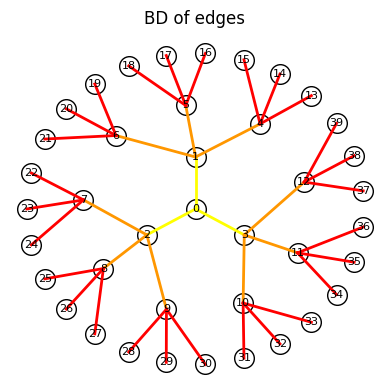

In [131]:
# 1. 构造树结构
G = nx.Graph()
# 根节点
root = 0
G.add_node(root)
node_id = 1

# 第一层：6 个子节点
layer1 = []
for _ in range(3):
    G.add_node(node_id)
    G.add_edge(root, node_id)
    layer1.append(node_id)
    node_id += 1

# 第二层：每个第一层节点连 3 个子节点
layer2 = []
for parent in layer1:
    for _ in range(3):
        G.add_node(node_id)
        G.add_edge(parent, node_id)
        layer2.append(node_id)
        node_id += 1

# 第三层：每个第二层节点连 2 个叶节点
layer3 = []
for parent in layer2:
    for _ in range(3):
        G.add_node(node_id)
        G.add_edge(parent, node_id)
        layer3.append(node_id)
        node_id += 1

# 确认节点总数
assert node_id == 1 + 3 + 9 + 27, f"节点数不对: {node_id}"

layer1=[1, 2, 3]
layer2=[6, 7, 8, 9, 10, 11, 12,4, 5]
layer3=[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

# 2. 同心布局
shells = [
    [root],
    layer1,
    layer2,
    layer3
]

pos = nx.shell_layout(G, shells)
N = G.number_of_nodes()



#——————————————————————————————————————————————————————————————————————————————

# 1. 遍历所有边，收集 (u, v, BD) 三元组  
edge_records = []
for u, v in G.edges():
    d = bd_exact(G,u, v)
    edge_records.append({
        "u": u,
        "v": v,
        "BD": d
    })

# 2. 构造 DataFrame  
df_edges = pd.DataFrame(edge_records, columns=["u", "v", "BD"])

# 3. 按 BD 排序（可选）  
df_edges = df_edges.sort_values("BD")

# 4. 保存到 CSV  
df_edges.to_csv("edge_biharmonic_distances.csv", index=False)

print("已将所有边的双调和距离保存到 edge_biharmonic_distances.csv")



# 1. 遍历所有边，收集 (u, v, BD) 三元组  
edge_records1 = []
for u, v in G.edges():
    d = backpush(G,u, v)
    edge_records1.append({
        "u": u,
        "v": v,
        "BD": d
    })

# 2. 构造 DataFrame  
df_edges1 = pd.DataFrame(edge_records1, columns=["u", "v", "BD"])

# 3. 按 BD 排序（可选）  
df_edges1 = df_edges1.sort_values("BD")

# 4. 保存到 CSV  
df_edges1.to_csv("edge_biharmonic_distances_my.csv", index=False)

print("已将所有边的双调和距离保存到 edge_biharmonic_distances_my.csv")




#——————————————————————————————————————————————————————————————————————————————


nodes = list(G.nodes())
M=np.zeros((N,N),dtype=float)

for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
        if i == j:
            M[i, j] = 0.0
        elif i < j:
            d = bd_exact(G,u, v)
            M[i, j] = d
            M[j, i] = d
            
df = pd.DataFrame(M, index=nodes, columns=nodes)
df.to_csv("biharmonic_distances.csv", index=True)

print("已将双调和距离矩阵保存到 biharmonic_distances.csv")  



#————————————————————————————————————————————————————————————————————————————————

# 提取距离数组并归一化到 [0,1]
ds = np.array(list(edge_bd.values()))
norm = (ds - ds.min()) / (ds.max() - ds.min() + 1e-12)

# —— 4. 构造 “红—橙—黄” 渐变色图谱 ——
cmap = LinearSegmentedColormap.from_list(
    "red_orange_yellow", ["red", "orange", "yellow"]
)

# 每条边的颜色
edge_colors = [cmap(norm[i]) for i in range(len(ds))]

# —— 5. 绘图 ——  
plt.figure(figsize=(4,4))

# 5.1 节点
nx.draw_networkx_nodes(
    G, pos,
    node_size=200,
    node_color="white",
    edgecolors="black",
    linewidths=1
)

# 5.2 边
# 需要保证 edge_colors 对应 G.edges() 的遍历顺序
for ( (u, v), color ) in zip(edge_bd.keys(), edge_colors):
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    plt.plot(
        [x1, x2], [y1, y2],
        color=color, linewidth=2
    )

# 5.3 节点编号
labels = {n: str(n) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

# 美化
plt.axis("off")
plt.title("BD of edges", pad=10)
plt.tight_layout()
plt.show()



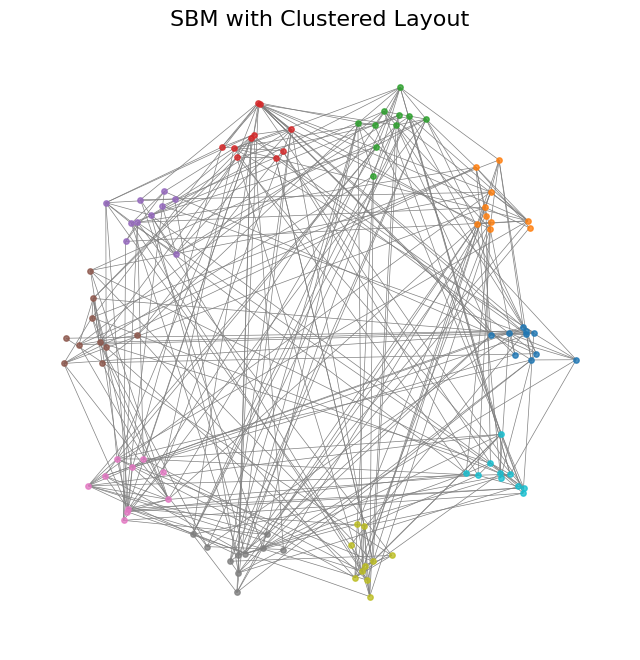

In [122]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def generate_sbm(n: int, k: int, p_intra: float, p_inter: float):
    base = n // k
    sizes = [base] * k
    sizes[-1] += n - base * k
    p = [[p_intra if i == j else p_inter for j in range(k)] for i in range(k)]
    G = nx.stochastic_block_model(sizes, p, seed=42)
    # 提取社区划分
    comms = [[] for _ in range(k)]
    for node, data in G.nodes(data=True):
        comms[data['block']].append(node)
    return G, comms

# 1. 生成图
N = 100
K = 10
P_INTRA = 0.3
P_INTER = 0.05
G, communities = generate_sbm(N, K, P_INTRA, P_INTER)


def clustered_layout(communities, radius=10, scale=1.0):
    """
    为每个社区生成一个在圆周上的中心点，
    然后将该社区内的节点随机分布在中心点附近。
    """
    k = len(communities)
    centers = []
    for i in range(k):
        theta = 2 * np.pi * i / k
        centers.append((radius * np.cos(theta), radius * np.sin(theta)))
    pos = {}
    for i, comm in enumerate(communities):
        cx, cy = centers[i]
        for node in comm:
            # 在中心附近加入小幅度随机噪声
            pos[node] = (
                cx + np.random.normal(scale=scale),
                cy + np.random.normal(scale=scale)
            )
    return pos

# 生成簇状布局
pos = clustered_layout(communities, radius=20, scale=2.0)

plt.figure(figsize=(8,8))
# 绘节点
colors = plt.cm.tab10(np.linspace(0,1,K))
for i, comm in enumerate(communities):
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=comm,
        node_size=15,
        node_color=[colors[i]],
        alpha=0.8
    )

# 绘边（抽样）
edge_sample_ratio = 1
edges = list(G.edges())
np.random.seed(42)
sampled = np.random.choice(len(edges), size=int(len(edges)*edge_sample_ratio), replace=False)
sampled_edges = [edges[i] for i in sampled]
nx.draw_networkx_edges(
    G, pos,
    edgelist=sampled_edges,
    width=0.5,
    alpha=1,
    edge_color='gray'
)

plt.axis('off')
plt.title("SBM with Clustered Layout", fontsize=16)
plt.show()





In [128]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Sample 100 distinct pairs
test_size=10
pairs = set()
rng = np.random.default_rng(42)
while len(pairs) < test_size:
    u, v = rng.integers(0, N, size=2)
    if u != v:
        pairs.add((u, v))
pairs = list(pairs)
print("Pairs:", pairs)

# Arrays to store
d_exact_arr = np.zeros(test_size)
d_approx_arr = np.zeros(test_size)


# Timers
t0 = time.perf_counter()
for i, (u, v) in enumerate(tqdm(pairs, desc="Exact BD")):
    d_exact_arr[i] = bd_exact(G, u, v)
t_exact = time.perf_counter() - t0

t0 = time.perf_counter()
for i, (u, v) in enumerate(tqdm(pairs, desc="Approx BD")):
    d_approx_arr[i] = backpush(G, u, v)
t_approx = time.perf_counter() - t0

print(f"Exact total time: {t_exact:.2f}s; Approx total time: {t_approx:.2f}s")
print("Exact distances:", d_exact_arr)
print("Approx distances:", d_approx_arr)

Exact_distances=np.array(d_exact_arr)
Approx_distances=np.array(d_approx_arr)

np.savetxt("Exact_distances1.txt", Exact_distances, fmt="%.8f")
np.savetxt("Approx_distances1.txt", Approx_distances, fmt="%.8f")

print("已将两个数组分别保存为 Exact_distances1.txt 和 Approx_distances1.txt")


Pairs: [(np.int64(8), np.int64(69)), (np.int64(51), np.int64(12)), (np.int64(43), np.int64(85)), (np.int64(52), np.int64(97)), (np.int64(65), np.int64(43)), (np.int64(83), np.int64(45)), (np.int64(8), np.int64(77)), (np.int64(20), np.int64(9)), (np.int64(73), np.int64(76)), (np.int64(71), np.int64(78))]


Approx BD: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]

Exact total time: 0.10s; Approx total time: 23.44s
Exact distances: [0.23894525 0.22352441 0.26612894 0.26673952 0.24283354 0.26015088
 0.23694041 0.20639196 0.31997137 0.21039421]
Approx distances: [0.20740065 0.22343604 0.26615475 0.28427096 0.27437403 0.26010846
 0.23812495 0.20618359 0.31996212 0.21024001]
已将两个数组分别保存为 Exact_distances1.txt 和 Approx_distances1.txt


        MAE      RMSE        R2  Mean Relative Error
0  0.008233  0.015161  0.769588             0.033505


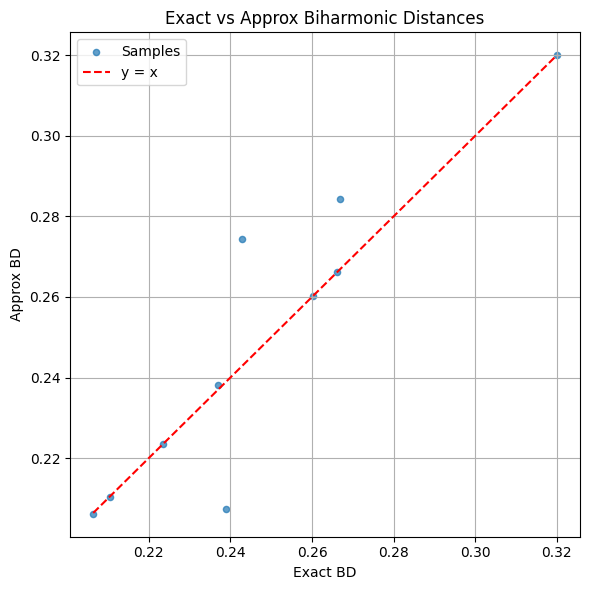

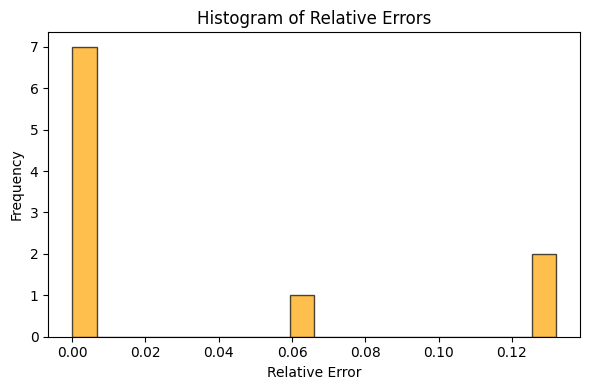

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. 读取数据
exact = np.loadtxt("Exact_distances1.txt")
approx = np.loadtxt("Approx_distances1.txt")

# 2. 计算误差和准确度指标
abs_error = np.abs(approx - exact)
rel_error = abs_error / (exact + 1e-12)

mae = np.mean(abs_error)
mse = np.mean((approx - exact) ** 2)
rmse = np.sqrt(mse)
mean_exact = np.mean(exact)
r2 = 1 - np.sum((approx - exact) ** 2) / np.sum((exact - mean_exact) ** 2)

metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2,
    "Mean Relative Error": np.mean(rel_error)
}

# 3. 输出指标表格
df_metrics = pd.DataFrame([metrics])
print(df_metrics)

# 4. 可视化
plt.figure(figsize=(6, 6))
plt.scatter(exact, approx, s=20, alpha=0.7, label="Samples")
plt.plot([exact.min(), exact.max()], [exact.min(), exact.max()], 'r--', label="y = x")
plt.xlabel("Exact BD")
plt.ylabel("Approx BD")
plt.title("Exact vs Approx Biharmonic Distances")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(rel_error, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel("Relative Error")
plt.ylabel("Frequency")
plt.title("Histogram of Relative Errors")
plt.tight_layout()
plt.show()


In [81]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. 读取完整图
path = r"C:\Users\zheng\Desktop\项目申请\pre-test\CA-CondMat.txt"
G = nx.read_edgelist(
    path,
    comments="#",
    delimiter="\t",
    nodetype=int,
    create_using=nx.Graph(),
)
print("完整图：", G.number_of_nodes(), "节点，", G.number_of_edges(), "边")




完整图： 23133 节点， 93497 边
